In [8]:
import json
from random import randint
from tqdm import tqdm

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np

import datetime as dt
from datetime import datetime
import time
from matplotlib.dates import date2num
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter


import warnings
warnings.filterwarnings("ignore")
import hdbscan
import nltk
import numpy as np
import pandas as pd
import random
import re
import spacy
import textacy

from gmplot import gmplot
from mapsplotlib import mapsplot as mplt
from nltk.corpus import twitter_samples
from nltk.tag import pos_tag_sents
from pymprog import *
from sklearn.cluster import DBSCAN
from sklearn.neighbors import DistanceMetric


In [9]:

file_paths = ['/media/disk1/data_from_CMU/garbage_trash_other_geocoded_data/geocoded_tweets2.json']
              
terms_on_interest = ['trash', 'garbage', 'pollution']

file_name_to_save_geocode_tweets = 'geocoded_trash_and_garbage_pollution__large_tweets_dict.pkl'

fig_name_to_save = 'trash_pollution_and_garbage_sample2.png'


def does_text_contain_any_of_the_terms(text, terms):
    text = text.lower()
    
    does_contain = False
    for term in terms:
        if term in text:
            does_contain = True
            
    return does_contain


In [10]:
%%time

all_dates = []
geo_coded_dates = []

geocoded_tweets_dict = []

for file_path in tqdm(file_paths):
    i = 0
    j = 0
    with open(file_path, 'r') as f_read:
        try:
            for line in f_read:
                try:
                    i+=1
                    tweet_dict = json.loads(line)

                    date = 0
                    timestamp = 0

                    if 'text' in tweet_dict:
                        text = tweet_dict['text']
                    else:
                        continue

                    if 'created_at' in tweet_dict and does_text_contain_any_of_the_terms(text, terms_on_interest):
                        d = datetime.strptime(tweet_dict['created_at'], '%a %b %d %H:%M:%S +0000 %Y');
                        date = time.mktime(d.timetuple())

                        all_dates.append(date)

                        if 'geo' in tweet_dict and tweet_dict['geo'] != None:
                            geocoded_tweets_dict.append(tweet_dict)        
                            j +=1
                            geo_coded_dates.append(date)

                        elif 'coordinates' in tweet_dict and tweet_dict['coordinates'] != None:
                            geocoded_tweets_dict.append(tweet_dict)   
                            j +=1 
                            geo_coded_dates.append(date)

                        elif 'place' in tweet_dict and tweet_dict['place'] != None and 'bounding_box' in tweet_dict['place'] and tweet_dict['place']['bounding_box'] != None and 'coordinates' in tweet_dict['place']['bounding_box'] and  tweet_dict['place']['bounding_box']['coordinates'] != None:
                            geocoded_tweets_dict.append(tweet_dict)   
                            j +=1 
                            geo_coded_dates.append(date)
                            
                except Exception as ex1:
                    print(ex1)

        except Exception as ex:
            print(ex)
        print(i, j)
        

100%|██████████| 1/1 [3:42:35<00:00, 13355.26s/it]

Unterminated string starting at: line 1 column 4811 (char 4810)
294848387 247244
CPU times: user 3h 30min 51s, sys: 6min 26s, total: 3h 37min 17s
Wall time: 3h 42min 35s


In [15]:
print("Total Number of Tweets :", i, "\nTotal Number of Tweets that we're interested :", j)

Total Number of Tweets : 294848387 
Total Number of Tweets that we're interested : 247244


In [16]:
try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle

with open(file_name_to_save_geocode_tweets, 'wb') as fp:
    pickle.dump({'geocoded_tweets_dict': geocoded_tweets_dict}, fp, protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
lons = []
lats = []
for tweet_dict in geocoded_tweets_dict:
    if 'geo' in tweet_dict and tweet_dict['geo']  != None and 'coordinates' in tweet_dict['geo'] and tweet_dict['coordinates'] != None:
        lon, lat = tweet_dict['geo']['coordinates']
    elif 'coordinates' in tweet_dict and tweet_dict['coordinates'] != None  and ['coordinates'] in tweet_dict['coordinates'] and \
            tweet_dict['coordinates']['coordinates'] != None:
        lat,lon = tweet_dict['coordinates']['coordinates']
    elif  'place' in tweet_dict :
        sample_coor = tweet_dict['place']['bounding_box']['coordinates']
        
        lat_vertices = []
        lon_vertices = []
        for coor in sample_coor[0]:
            lat_vertices.append(coor[0])
            lon_vertices.append(coor[1])

        lat = np.mean(lat_vertices)    
        lon = np.mean(lon_vertices)    

    else:
        continue
    
    lons.append(lon)
    lats.append(lat)

In [18]:

normal_dates = []

from datetime import datetime

timestamp = geo_coded_dates

#convert timestamp to datetime object

for idx in range(len(timestamp)):
    
    dt_object = datetime.fromtimestamp(timestamp[idx])
    normal_dates.append(str(dt_object))

print(len(normal_dates))


247244


In [20]:

## Adding count 1 to each tweet for hexabin analysis
tw = [1]*len(geo_coded_dates)
print(len(tw))


247244


In [28]:

## Creating DataFrame

df = pd.DataFrame(list(zip(tw, normal_dates, lons, lats)),
                 columns = ["count", "Date", "to_lat", "to_lon"])

In [29]:

## DataFrame to geopandas dataframe

import geopandas as gpd

gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy ( x = df ['to_lat'], 
                                                          y = df ['to_lon']))


## 3D Visulization of tweets

In [30]:


from keplergl import KeplerGl
map1 = KeplerGl(height=500)
map1
map1.add_data(data=gdf,name='Trash_Tweets')
map1.save_to_html(file_name = 'trash_tweets.html')



User Guide: https://docs.kepler.gl/docs/keplergl-jupyter
Map saved to trash_tweets.html!


## 2D Visulization of Tweets

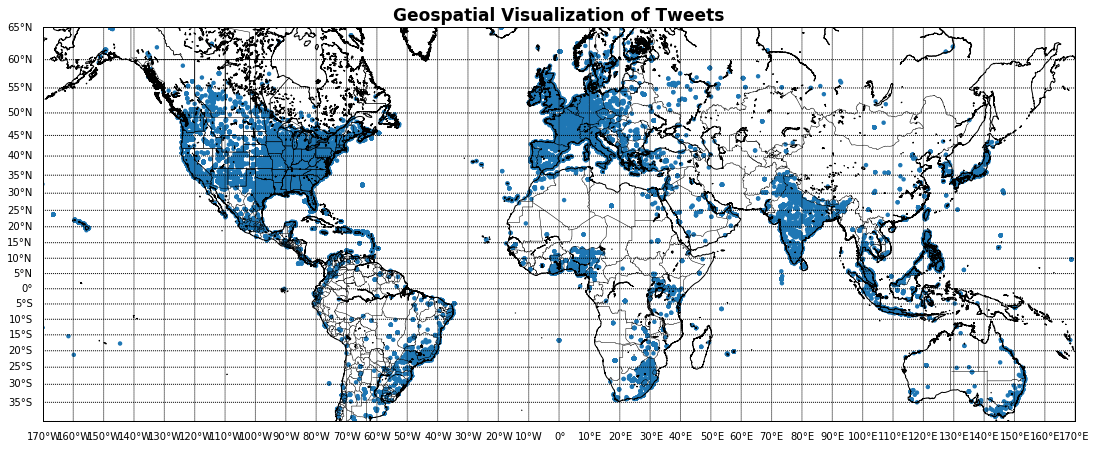

In [31]:
        
fig1 = plt.figure()
fig1.set_size_inches(18.5, 10.5)
ax1 = fig1.add_subplot(111)

m = Basemap(projection='merc',llcrnrlat=-40,urcrnrlat=65,\
            llcrnrlon=-170,urcrnrlon=170,lat_ts=20,resolution='i')
m.drawcoastlines()
m.drawcountries()
# draw parallels and meridians.
parallels = np.arange(-90.,91.,5.)
# Label the meridians and parallels
m.drawparallels(parallels,labels=[True,False,False,False])
# Draw Meridians and Labels
meridians = np.arange(-180.,181.,10.)
m.drawmeridians(meridians,labels=[True,False,False,True])
m.drawmapboundary(fill_color='white')
m.drawstates()


x,y = m(lats,lons )
jet = plt.cm.get_cmap('jet')
sc = plt.scatter(x,y,  vmin=0, vmax =10, s=20, edgecolors='none') #c=colors, cmap=jet

plt.title('Geospatial Visualization of Tweets', fontsize=17, weight='bold')

fig1.savefig(fig_name_to_save)   # save the figure to file
# plt.close(fig1) 